In [1]:
from binance.spot import Spot 
from sys import stderr
import sys, os,datetime,requests,json,pandas as pd,numpy as np
import time,math, gc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.model_selection import train_test_split
min_max_scaler = sklearn.preprocessing.MinMaxScaler()



import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def import_api(time_last,symbol="BTCUSDT",limit=12*60,interval="1m"):
    params={"symbol":symbol,"limit":limit,"interval":interval,"endTime":time_last,"startTime":(time_last-12*3600*1000)}
    r=requests.get(url="https://api.binance.com/api/v3/klines", params=params)
    df=pd.DataFrame(r.json())
    return df

def transform_df (df):
    column_names=['Open_time','Open','High','Low','Close','Volume','Close_time','Quote_asset_volume',
               'Number_of_trades','Taker_buy_base_asset_volume','Taker_buy_quote_asset_volume','Ignore']
    df=df.reset_index(drop=True)
    df.set_axis(column_names,axis=1,inplace=True)
    for col in df.columns:
        df[col] = df[col].astype(float)
    weekday=[]
    month=[]
    for i in range(df['Open'].size):
        dt_open=datetime.datetime.fromtimestamp(df['Open_time'][i]//1000)
        dt_close=datetime.datetime.fromtimestamp(df['Close_time'][i]//1000)
        df['Open_time'][i]=dt_open.hour*3600+dt_open.minute*60+dt_open.second
        df['Close_time'][i]=dt_close.hour*3600+dt_close.minute*60+dt_close.second
        weekday.append(dt_open.weekday())
        month.append(dt_open.month)
        #df['Open_time'][i]=dt_open.strftime("%I:%M:%S")
        #df['Close_time'][i]=dt_close.strftime("%I:%M:%S")
    df['weekday']=weekday
    df['month']=month
    df=df.drop(df.columns[[7,10,11,13]],axis=1)
    del(month)
    del(weekday)
    return df


def moving_average(data,range_,concat=60):
    leftover=len(data)%concat
    data=data[::concat].reset_index(drop=True)
    mean=[]
    arr=[]
    for i in range(range_):
        this_mean=0
        for j in range(i+1):
            this_mean+=data[j]
        mean.append(this_mean/(j+1))
    if leftover:
        data_size=len(data)-1
    else:
        data_size=len(data)
    for i in range(range_,data_size):
        this_mean=data[i]
        for j in range(1,range_):
            this_mean+=data[i-j]
        mean.append(this_mean/(range_))
    arr=leftover*[mean[0]]
    for i in range(len(mean)):
        arr+=concat*[mean[i]]
    
    
    return arr

def generate_previous(df,count,col_name):
    #idxes=
    df=df.reset_index(drop=True)
    values=list(df[col_name][0:count])
    columns={}
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        columns[this_name]=[]
    for i in range(count,df[col_name].size):
        for j in range(count):
            this_name="prev_"+col_name+"_"+str(j+1)
            columns[this_name].append(values[-(j+1)])
        values.pop(0)
        values.append(df[col_name][i])
    size=df[col_name].size
    df=df[count:size]
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        df[this_name]=columns[this_name]
    
    return df.reset_index(drop=True)

def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in (df.iloc[i:i+window_size].drop("target",axis=1).values)]
        X.append(row)
        label = df["target"][i+window_size-1]
        y.append(label)
    return np.array(X), np.array(y)

def tensor_to_X_y(data, window_size=5):
    X = []
    y = []
    data=pd.DataFrame(data.tolist())
    columns=data.columns
    for i in range(len(data)-window_size):
        row = [a for a in (data.iloc[i:i+window_size].drop(data.columns[-1],axis=1).values)]
        X.append(row)
        label = data[data.columns[-1]][i+window_size-1]
        y.append(label)
    return np.array(X), np.array(y)

def preprocess_df(df,target_range,hours,hours_interval,days,days_interval,scaling_range=0.2):
    target=[]
    concat_hours=3
    concat_days=8
    window=target_range
    for i in range(df["Open"].size-window):
        target.append(df["Open"][i+window])
    df=df[0:df["Open"].size-window]
    df["target"]=target
    #df=df.drop(["Close_time","Taker_buy_base_asset_volume","Volume","Close","Low","High","Number_of_trades"],axis=1)
    df=df.drop(["Close_time","Taker_buy_base_asset_volume","Volume","Close","Low","High","Number_of_trades"],axis=1)
    for i in range(1,hours//hours_interval+1):
        df["mean_"+str(i*hours_interval)+"_hours"]=moving_average(df["Open"],i*(12//concat_hours)*hours_interval,concat_hours)
    for i in range(1,days//days_interval+1):
        df["mean_"+str(i*days_interval)+"_days"]=moving_average(df["Open"],i*12*(24//concat_days)*days_interval,concat_days)
    drop_col=["Open",'Open_time','weekday']
    open_delta=[]
    df["weekday"]=df["weekday"].astype(float)
    for col in df.drop(drop_col,axis=1).columns:
        for i in range(df["Open"].size):
            df[col][i]=df[col][i]/df["Open"][i]
    for i in range(1,df["Open"].size):
        df["Open_time"][i]/=86400
        df["weekday"][i]/=6.0
        delta=df["Open"][i]-df["Open"][i-1]
        open_delta.append(delta/df["Open"][i])
    df=df.drop(0,axis=0)
    cols=df.columns[3:]
    for i in cols:
        for j in range(1,df["Open"].size):
            df[i][j]=(df[i][j]-(1-scaling_range))/(scaling_range*2)
    return df

def upscale(input_data,scaling_range=0.2):
    return input_data*2*scaling_range-scaling_range+1

In [3]:
class autoencoder(nn.Module):
    def __init__(self,drop,input_size,hidden_size,test_size):
        super(autoencoder, self).__init__()
        self.norm=nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc3 = nn.Linear(hidden_size, test_size,bias=True)
        self.fc4 = nn.Linear(test_size, hidden_size,bias=True)
        self.fc5 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc6 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc7 = nn.Linear(hidden_size, input_size,bias=True)
        self.dropout = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(F.relu(x))
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = self.dropout(F.relu(x))
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        return x
    def encode (self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x
    
class Net(nn.Module):
    def __init__(self,drop,hidden_size,input_size):
        super(Net, self).__init__()
        self.norm=nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.LSTM(num_layers=1,input_size=input_size, hidden_size=hidden_size,batch_first=True)
        self.fc2 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc3 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc4 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc5 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc6 = nn.Linear(hidden_size, 1,bias=True)
        self.dropout = nn.Dropout(drop)
    def forward(self, x):
        x,_ = self.fc1(x)
        x=x[:,-1,:]
        x=F.tanh(x)
        x = self.dropout(x)
        x = F.logsigmoid(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x
    def predict(self, x):
        x,_ = self.fc1(x)
        x=x[:,-1,:]
        x=F.tanh(x)
        x = self.dropout(x)
        x = F.logsigmoid(self.fc5(x))
        #x = self.dropout(x)
        x = self.fc6(x)
        return x

In [4]:
def encode(encoder,data):
    encoded=encoder.encode(torch.tensor(data,device="cuda"))
    #if (encoded.shape.shape!=1):
    arr=torch.tensor([0 for i in encoded[:,0]],device="cuda")
    #print(encoded[:,1])
    count=0
    for i in range(encoded.shape[1]):
        if (set(encoded[:,i].tolist())!={0.0}):
            arr=torch.cat((arr,encoded[:,i]),0)
            count+=1
    arr=torch.reshape(arr,[count+1,encoded.shape[0]])[1:]
    arr=torch.reshape(arr,[encoded.shape[0],count])
    return arr

def tensor_to_sequences(data, window_size=5):
    X = []
    data=pd.DataFrame(data.tolist())
    for i in range(len(data)-window_size):
        row = [a for a in (data.iloc[i:i+window_size].values)]
        X.append(row)
    return np.array(X)

In [5]:
def backtest(
net,
wallet_start=1000,
min_sell_threshold=1.0008, #min value for selling
buying_threshold=1.0015, #min prediction for buying
purchase_size=0.2,
net_repeating=5,
comission=0.001,
stop_loss=0.985,
loss_multiplier=1,
loss_count_max=3
):


    wallet=wallet_start
    desired_sell_cost=0
    min_sell_value=0
    wallet_dynamics=[]
    #buying_threshold=upscale(buying_threshold)
    #min_sell_threshold=upscale(min_sell_threshold)
    buy=0
    sell=0
    backtest_preds=[]
    positions=[]
    loss_count=0

    for i in range(len(test_data)):
        this_open=test_opens[i]
        array=[]
        preds=[]
        for j in range(net_repeating):
            array.append(net(torch.tensor([test_data[i]],device="cuda")).tolist()[0])
        array=np.asarray(array)
        for j in range(len(array[0])):
            preds.append(np.mean(array[:,j]))
        test_prediction=upscale(preds[0],0.2)*this_open #getting prediction

        buying_value=buying_threshold*this_open
        backtest_preds.append(test_prediction)
        if (buy==0 and test_prediction>buying_value): #buy when prediction > min sell value 
            buy=1
            wallet-=this_open*purchase_size*(1+comission)
            desired_sell_cost=min_sell_value
            #wallet_dynamics.append(wallet-wallet_start)
            min_sell_value=min_sell_threshold*this_open
            positions.append(this_open)
        if (buy==1 and this_open>=min_sell_value): #sell when cost is at least min sell value
            buy=0
            wallet+=this_open*purchase_size*(1-comission)
            wallet_dynamics.append(wallet-wallet_start)
            positions.pop(0)
            loss_count=0
        if (buy==1 and this_open<positions[0]*stop_loss):
            buy=0
            wallet+=this_open*purchase_size*(1-comission)
            wallet_dynamics.append(wallet-wallet_start)
            positions.pop(0)
            loss_count=0
        if (buy==1 and test_prediction<positions[0]*(1-buying_threshold*loss_multiplier)):
            loss_count+=1
            if (loss_count>=loss_count_max):
                loss_count=0
                buy=0
                wallet+=this_open*purchase_size*(1-comission)
                wallet_dynamics.append(wallet-wallet_start)
                positions.pop(0)
    #if(buy==1):
        #wallet+=test_opens[-1]*purchase_size
        #wallet_dynamics.append(wallet-wallet_start)
    gc.collect()
    return wallet_dynamics

In [6]:
directory="G:\Учеба\биржа"
symbol="ETHUSDT"

In [7]:
encoder=autoencoder(0,41,64,10).cuda().double()
encoder.load_state_dict(torch.load(directory+"\\encoder_05-07-2022_22-03-48_64_10.pth"))
#encoder.eval()

<All keys matched successfully>

In [8]:
#count=2*365
#time_now=datetime.datetime.now()
#time_now=round(time_now.timestamp())*1000
#df=transform_df(import_api(time_now-12*3600*1000,"ETHUSDT",90,"5m"))
#size=df["Open"].size
#df["Open"][size-1]

In [9]:
time_now=datetime.datetime.now()
time_now=round(time_now.timestamp())*1000
time_now-=40*24*3600*1000
df1=pd.DataFrame()
for i in range(2*45): #2*365
    df1=import_api(time_now-12*3600*1000*i,symbol,720,"5m").append(df1)
df1=transform_df(df1)
df1=preprocess_df(df1,4,24,1,15,1).reset_index(drop=True)

C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_10740/3385055909.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"]=target


In [10]:
#df1.to_csv(directory+"\\20_05-25_06_trades_data.csv")
#df1=pd.read_csv(directory+"\\20_06-7_07_trades_data.csv").reset_index(drop=True).drop("Unnamed: 0",axis=1)
#df1=pd.read_csv(directory+"\\1_07-17_07_trades_data.csv").reset_index(drop=True).drop("Unnamed: 0",axis=1)
#df1=pd.read_csv(directory+"\\17_07-2_08_trades_data.csv").reset_index(drop=True).drop("Unnamed: 0",axis=1)
#df1=pd.read_csv(directory+"\\5_07-5_08_trades_data.csv").reset_index(drop=True).drop("Unnamed: 0",axis=1)
df1=pd.read_csv(directory+"\\20_05-25_06_trades_data.csv").reset_index(drop=True).drop("Unnamed: 0",axis=1)

In [11]:
leftover=10
beginning=-(5*12*24*8)
opens=df1["Open"]
test_opens=np.asarray(df1["Open"][beginning:-leftover])
encoded=encode(encoder,df1.drop(["Open","target"],axis=1).to_numpy()[:]).tolist()
encoded=torch.tensor(encoded,device="cuda")
window_size=30
seq=tensor_to_sequences(encoded[-(window_size+1):],window_size)
test_data=tensor_to_sequences(encoded[beginning:-leftover],window_size)
for i in range(len(test_data)):
        for j in range(test_data[i].shape[0]):
            test_data[i][j]=np.array(test_data[i][j])

<AxesSubplot:>

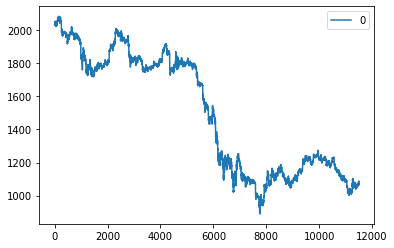

In [12]:
pd.DataFrame(test_opens)[:].plot()

In [13]:
names=["\\net_15-07-2022_15-18-03_3_64",
       "\\net_12-07-2022_16-24-30_3_64",
       "\\net_12-07-2022_17-54-06_3_128",
      "\\net_16-07-2022_22-45-20_3_64",
      "\\net_17-07-2022_00-01-19_3_64",
      "\\net_23-07-2022_16-40-32_3_96",
      "\\net_25-07-2022_13-34-39_3_96",#6
      "\\net_25-07-2022_16-58-19_3_96"]

In [15]:
name=names[7]
path=directory+name
net=Net(0.6,96,3).cuda().double()
net.load_state_dict(torch.load(path+".pth"))
#net.eval()

<All keys matched successfully>

In [14]:
#0.0026 	0.00325 	0.1 	2 	\net_25-07-2022_16-58-19_3_96
#0.0026 	0.00225 	0.1 	3 	\net_25-07-2022_16-58-19_3_96

#0.0020 	0.002 	0.15 	3 	\net_23-07-2022_16-40-32_3_96
#0.0035 	0.002 	0.15 	3 	\net_23-07-2022_16-40-32_3_96
#0.003 	0.0045 	0.15 	1 	\net_23-07-2022_16-40-32_3_96
#0.003 	0.002 	0.15 	3 	\net_25-07-2022_16-58-19_3_96
#results                                      0.136652
#min_sell                                        0.003
#buying_threshold_arr                           0.0035
#stop_loss_arr                                    0.15
#net_repeating_arr                                   2
#name                    \net_23-07-2022_16-40-32_3_96

In [15]:
#results                                 -2.212807
#min_sell                                    0.004
#buying_threshold                            0.003
#stop_loss                                    0.15
#loss_multiplier                                 3
#loss_count_max                                  3
#net_repeating                                   3
#name                \net_25-07-2022_16-58-19_3_96

In [ ]:
#results                                       0.0
#min_sell                                    0.004
#buying_threshold                            0.004
#stop_loss                                    0.15
#loss_multiplier                                 1
#loss_count_max                                  1
#net_repeating                                   2
#name                \net_25-07-2022_16-58-19_3_96

In [16]:
#most optimal: 0.003 	0.0045 	0.15 	1 	\net_23-07-2022_16-40-32_3_96, loss_multiplier=4,loss_count_max=2, mean=-0.08

In [16]:
min_sell=0.004
buying_threshold=0.003
stop_loss=0.15
loss_multiplier=3
loss_count_max=3
net_repeating=3
ressss=[]
for i in range(100):
    backtest_results=backtest(net,wallet_start=1000,min_sell_threshold=1+min_sell,buying_threshold=1+buying_threshold,purchase_size=0.01,net_repeating=net_repeating,comission=0.001,stop_loss=1-stop_loss,loss_multiplier=loss_multiplier,loss_count_max=loss_count_max)
    if (backtest_results!=[]):
        ressss.append(backtest_results[-1])
    else:
        ressss.append([0])

C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_10740/1856368297.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  array.append(net(torch.tensor([test_data[i]],device="cuda")).tolist()[0])
G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [40]:
#pd.DataFrame(backtest_results).plot()

G:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:997: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")


<AxesSubplot:>

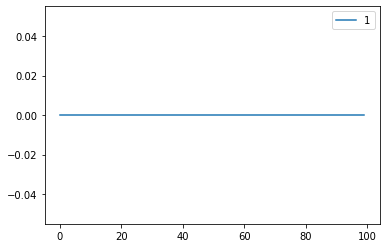

In [31]:
pd.DataFrame([np.sort(ressss),[0 for i in range(len(ressss))]]).T.plot()
#3

In [30]:
pd.DataFrame([np.sort(ressss),[0 for i in range(len(ressss))]]).T.describe()

G:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:997: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")


,0,1
count,100,100.0
unique,99,1.0
top,[0],0.0
freq,2,100.0


In [33]:
ressss_no_net=[]
for i in range(4):
    backtest_results_no_net=backtest(net,wallet_start=1000,min_sell_threshold=1.002,buying_threshold=0.5,purchase_size=0.002,net_repeating=1,comission=0.001,stop_loss=0.85)
    ressss_no_net.append(backtest_results_no_net[-1])

G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


<AxesSubplot:>

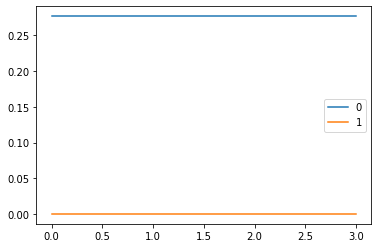

In [34]:
pd.DataFrame([np.sort(ressss_no_net),[0 for i in range(len(ressss_no_net))]]).T.plot()

In [35]:
pd.DataFrame([np.sort(ressss_no_net),[0 for i in range(len(ressss_no_net))]]).T.describe()

,0,1
count,4.000000,4.0
mean,0.276864,0.0
std,0.000000,0.0
min,0.276864,0.0
25%,0.276864,0.0
50%,0.276864,0.0
75%,0.276864,0.0
max,0.276864,0.0


In [98]:
#pd.DataFrame(backtest_results).plot()

In [17]:
backtest_results=[]
backtest_results_means=[]
stop_loss=0.15
sell=0.0026
net_repeats=1
buy=0.0045
name=names[7]
#names_arr=names[6:]
#for i in range(len(names_arr)):
#    name=names_arr[i]
#    print(name)
#    word=""
#    for k in range(1,len(name)):
#        if(name[-k]!="_"):
#            word=name[-k]+word
#        else:
#            break
#word=int(word)
path=directory+name
net=Net(0.6,96,3).cuda().double()
net.load_state_dict(torch.load(path+".pth"))
for loss_multiplier in range(1,5):
    for loss_count_max in range(loss_count_min,5):    
        print(loss_count_max)
        for buy in np.arange(0.002,0.0086,0.0015):
            #print(buy)
            for sell in np.arange(0.002,0.0081,0.0015):
                for net_repeats in range(1,5,1):
                    arr=[]
                    for i in range(10):
                        backtest_results.append([backtest(net,wallet_start=1000,min_sell_threshold=1+sell,buying_threshold=1+buy,purchase_size=0.01,net_repeating=net_repeats,comission=0.001,stop_loss=1-stop_loss,loss_multiplier=loss_multiplier,loss_count_max=loss_count_max),stop_loss,buy,sell,net_repeats,name,loss_multiplier,loss_count_max])
                        arr.append(backtest_results[-1][0])
                    backtest_results_means.append(np.mean(arr))

3


G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
G:\anaconda3\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
G:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
G:\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4
3
4
3
4
3
4


In [13]:
#backtest_results=[]
#backtest_results_means=[]
stop_loss=0.15
sell=0.0026
buy=0.0045
loss_multiplier=1
loss_count_max=3
net_repeating=1
#print(a)
names_arr=names[5:]
for loss_multiplier in np.arange(0,11,1):
    print(loss_multiplier)
    for loss_count_max in np.arange(1,7,1):
    #for net_repeats in range(1,4,1):
        arr=[]
        for i in range(30):
            backtest_results.append([backtest(net,wallet_start=1000,min_sell_threshold=1.003,buying_threshold=1.0045,purchase_size=0.01,net_repeating=1,comission=0.001,stop_loss=0.85,loss_multiplier=loss_multiplier,loss_count_max=loss_count_max),loss_count_max,loss_multiplier,sell,net_repeating,name])
            arr.append(backtest_results[-1][0])
        backtest_results_means.append(np.mean(arr))

0


C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_14592/1856368297.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  array.append(net(torch.tensor([test_data[i]],device="cuda")).tolist()[0])
G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
G:\anaconda3\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1
2
3
4
5
6
7
8
9
10


In [14]:
#print(a,b,c,d)

In [18]:
results_1=[]
results_2=[]
min_sell_threshold_arr=[]
buying_threshold_arr=[]
net_repeating_arr=[]
stop_loss_arr=[]
net_repeating_arr=[]
net_name_arr=[]
loss_multiplier_arr=[]
loss_count_max_arr=[]
for i in range(len(backtest_results)):
    results_1.append(backtest_results[i][0])
    stop_loss_arr.append(backtest_results[i][1])
    buying_threshold_arr.append(backtest_results[i][2])
    min_sell_threshold_arr.append(backtest_results[i][3])
    net_repeating_arr.append(backtest_results[i][4])
    net_name_arr.append(backtest_results[i][5])
    loss_multiplier_arr.append(backtest_results[i][6])
    loss_count_max_arr.append(backtest_results[i][7])
for i in range(len(results_1)):
    if (results_1[i]!=[]):
        results_2.append(results_1[i][-1])
    else:
        results_2.append(0)

In [19]:
np.max(results_2)

1.8188362000001916

In [20]:
Backtest_results_df=pd.DataFrame({"results":results_2,
              "min_sell":min_sell_threshold_arr,
              "buying_threshold":buying_threshold_arr,
              "stop_loss":stop_loss_arr,
                "loss_multiplier":loss_multiplier_arr,
              "loss_count_max":loss_count_max_arr,                 
              "net_repeating":net_repeating_arr,
                "name":net_name_arr
                                 })
Trades_backtest_data=pd.DataFrame(results_1)

In [21]:
time_now=datetime.datetime.now()
time_now=time_now.strftime("\\Backtest_results_7_df_%d-%m-%Y_%H-%M-%S")
path=directory
end=".csv"
path=path+time_now+end
Backtest_results_df.to_csv(path)
path=directory
time_now=datetime.datetime.now()
time_now=time_now.strftime("\\Trades_backtest_7_data_%d-%m-%Y_%H-%M-%S")

path=path+time_now+end
Trades_backtest_data.to_csv(path)

In [18]:
df2=pd.read_csv(directory+"\\Backtest_results_7_df_15-08-2022_23-20-59.csv").reset_index(drop=True).drop("Unnamed: 0",axis=1)
#df2=Backtest_results_df

<AxesSubplot:>

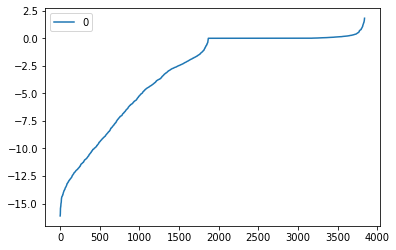

In [19]:
pd.DataFrame(np.sort(df2["results"])).plot()

In [11]:
df2["results"].describe()

count    3840.000000
mean       -3.075437
std         4.245557
min       -16.122605
25%        -5.606031
50%         0.000000
75%         0.000000
max         1.818836
Name: results, dtype: float64

In [62]:
#arr=np.where(df2["results"]>0.0,df2["results"],np.nan)
#arr=df2["results"]

In [127]:
pd.DataFrame(np.sort(arr)).dropna().reset_index(drop=True).plot()

In [61]:
#arr=np.where(df2["results"]>10,df2[:],np.nan)#.dropna()
#for i in range(df2["results"].size):
#    if (df2["results"][i]<-1):
#        df2=df2.drop(i)
#df2=df2.reset_index(drop=True)
#df2

In [20]:
df2.describe()

,results,min_sell,buying_threshold,stop_loss,loss_multiplier,loss_count_max,net_repeating
count,3840.000000,3840.000000,3840.000000,3.840000e+03,3840.00000,3840.000000,3840.00000
mean,-3.075437,0.003000,0.003500,1.500000e-01,2.50000,3.500000,2.50000
std,4.245557,0.000817,0.001118,1.082608e-14,1.11818,0.500065,1.11818
min,-16.122605,0.002000,0.002000,1.500000e-01,1.00000,3.000000,1.00000
25%,-5.606031,0.002000,0.002750,1.500000e-01,1.75000,3.000000,1.75000
50%,0.000000,0.003000,0.003500,1.500000e-01,2.50000,3.500000,2.50000
75%,0.000000,0.004000,0.004250,1.500000e-01,3.25000,4.000000,3.25000
max,1.818836,0.004000,0.005000,1.500000e-01,4.00000,4.000000,4.00000


In [21]:
same_results_count=[]
same=0
same_count=1
cols=df2.columns.drop("results")
res_threshold=0.01
res_threshold_arr=[]
res_count=0
for i in range(1,df2["results"].size):
    same=1
    for j in cols:
        if (df2[j][i]!=df2[j][i-1]):
            same=0
            same_results_count.append(same_count)
            res_threshold_arr.append(res_count)
            same_count=1
            res_count=0
            break
    if(same==1):
        same_count+=1
        if (df2["results"][i]>=res_threshold):
            res_count+=1

In [22]:
#res_threshold_arr

In [23]:
res_indexes=[]
res_count_threshold=9
for i in range(len(res_threshold_arr)):
    if (res_threshold_arr[i]>=res_count_threshold):
        res_indexes.append(i)
res_indexes

[166, 214, 302]

In [26]:
res_indexes_multi=[]
for i in range(len(res_indexes)):
    res_indexes_multi.append(res_indexes[i]*batch_size)
res_indexes_multi

[1660, 2140, 3020]

<AxesSubplot:>

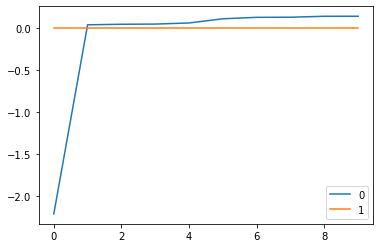

In [25]:
x=214
batch_size=10
#arr_2_part=arr_2[batch_size*(x-1):batch_size*x]
arr_2_part=df2["results"][batch_size*(x):batch_size*(x+1)]
pd.DataFrame([np.sort(arr_2_part),[0 for i in range(len(arr_2_part))]]).T.dropna().reset_index(drop=True).plot()

In [97]:
#df2_rows=[]
#sum_successes=-1
#sum_threshold=15
#for i in range(len(same_results_count)):
#    sum_successes+=same_results_count[i]
#    if (same_results_count[i]>=sum_threshold):
#        df2_rows.append(sum_successes)
#df2_rows

In [29]:
df2.iloc[x*batch_size+3]

results                                    0.0442
min_sell                                    0.004
buying_threshold                            0.003
stop_loss                                    0.15
loss_multiplier                                 3
loss_count_max                                  3
net_repeating                                   3
name                \net_25-07-2022_16-58-19_3_96
Name: 2143, dtype: object

In [40]:
backtest_results=[]
backtest_results_means=[]
stop_loss=0.15
sell=0.0026
net_repeating=1
buy=0.0045
names_arr=names[5:]
for i in res_indexes_multi:
    print(i)
    #loss_multiplier=df2["loss_multiplier"][i]
    #loss_count_max=df2["loss_count_max"][i]
    name=df2["name"][i]
    print(name)
    word=""
    for k in range(1,len(name)):
        if(name[-k]!="_"):
            word=name[-k]+word
        else:
            break
    word=int(word)
    path=directory+name
    net=Net(0.6,word,3).cuda().double()
    net.load_state_dict(torch.load(path+".pth"))
    sell=df2["min_sell"][i]
    buy=df2["buying_threshold"][i]
    net_repeats=df2["net_repeating"][i]
    loss_multiplier=df2["loss_multiplier"][i]
    loss_count_max=df2["loss_count_max"][i]
    stop_loss=df2["stop_loss"][i]
    arr=[]
    for j in range(50):
        backtest_results.append([backtest(net,wallet_start=1000,min_sell_threshold=1+sell,buying_threshold=1+buy,purchase_size=0.01,net_repeating=net_repeats,comission=0.001,stop_loss=1-stop_loss,loss_multiplier=loss_multiplier,loss_count_max=loss_count_max),stop_loss,buy,sell,net_repeats,name])
        if (backtest_results[-1][0]!=[]):
            arr.append([backtest_results[-1][0][-1]])
        else:
            arr.append([0])
    #backtest_results_means.append(np.mean(arr))

1660
\net_25-07-2022_16-58-19_3_96


G:\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


2140
\net_25-07-2022_16-58-19_3_96
3020
\net_25-07-2022_16-58-19_3_96


In [41]:
arr_2=[]
for i in range(len(backtest_results)):
    if (backtest_results[i][0]!=[]):
        arr_2.append(backtest_results[i][0][-1])
    else:
        arr_2.append(0)

<AxesSubplot:>

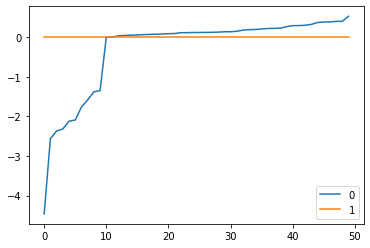

In [62]:
x=2
batch_size=50
arr_2_part=arr_2[batch_size*(x-1):batch_size*x]
#arr_2_part=df2["results"][batch_size*(x-1):batch_size*x]
pd.DataFrame([np.sort(arr_2_part),[0 for i in range(len(arr_2_part))]]).T.dropna().reset_index(drop=True).plot()

In [63]:
pd.DataFrame(arr_2_part).describe()

,0
count,50.000000
mean,-0.293254
std,1.044336
min,-4.465422
25%,0.038666
50%,0.119670
75%,0.223371
max,0.530482
